In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)

# Load the .ori orientation file
ori_path = "DC3_final_530km_3_month_with_slew_15sbins_EarthLocal.ori"
ori_df = pd.read_csv(
    ori_path,
    delim_whitespace=True,
    skiprows=1,
    header=None,
    names=["prefix", "timestamp", "x_lat", "x_lon", "z_lat", "z_lon", "altitude_km", "Earth_lat", "Earth_lon"]
)

ori_df.head()

C:\Users\mikec\AppData\Local\Temp\ipykernel_19568\3539692972.py:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ori_df = pd.read_csv(


,prefix,timestamp,x_lat,x_lon,z_lat,z_lon,altitude_km,Earth_lat,Earth_lon
0,OG,1.835487e+09,59.274529,22.415898,-30.725471,22.415898,530.222097,-0.000190,27.047042
1,OG,1.835487e+09,58.504010,22.732337,-31.495990,22.732337,530.219997,-0.000184,27.927215
2,OG,1.835487e+09,57.732736,23.048787,-32.267264,23.048787,530.216960,-0.000177,28.807377
3,OG,1.835487e+09,56.960731,23.365378,-33.039269,23.365378,530.212986,-0.000171,29.687529
4,OG,1.835487e+09,56.188017,23.682244,-33.811983,23.682244,530.208077,-0.000165,30.567670


In [3]:
# Drop the non-informative 'prefix' column (always 'OG')
ori_df = ori_df.drop(columns=["prefix"])

# Convert timestamps to datetime format
ori_df["timestamp"] = pd.to_datetime(ori_df["timestamp"], unit='s')

# Keep only the first day of data from 13:00:00 onward
start_time = pd.Timestamp("2028-03-01 13:00:00")
end_time = pd.Timestamp("2028-03-02 0:00:00")
ori_df = ori_df[
    (ori_df["timestamp"] >= start_time) & (ori_df["timestamp"] < end_time)
]

ori_df.head()

,timestamp,x_lat,x_lon,z_lat,z_lon,altitude_km,Earth_lat,Earth_lon
2740,2028-03-01 13:00:00,49.193163,128.323431,40.806837,308.323431,527.911789,0.000012,277.060694
2741,2028-03-01 13:00:15,49.273989,129.395352,40.726011,309.395352,527.857926,0.000011,277.939788
2742,2028-03-01 13:00:30,49.369335,130.463765,40.630665,310.463765,527.803767,0.000011,278.818869
2743,2028-03-01 13:00:45,49.479109,131.528122,40.520891,311.528122,527.749328,0.000010,279.697939
2744,2028-03-01 13:01:00,49.603220,132.587880,40.396780,312.587880,527.694624,0.000009,280.576996


In [4]:
# Load the detector data and timestamps
time_array = np.load("time_array.npy")
rates = np.load("total_rates.npy")

# Remove the extra dimension from rates array
rates = np.squeeze(rates)

# Convert time_array to datetime
time_series = pd.to_datetime(time_array, unit='s')

# Create DataFrame with detector rates and timestamps
rates_df = pd.DataFrame(rates, columns=[f"detector_{i+1}" for i in range(rates.shape[1])])
rates_df["timestamp"] = time_series
rates_df = rates_df[["timestamp"] + [col for col in rates_df.columns if col != "timestamp"]]

#Filter the DataFrame to keep only the first day of data from 13:00 onward
clean_rates_df = rates_df[
    (rates_df["timestamp"] >= start_time) & (rates_df["timestamp"] < end_time)
].copy()

# Check columns
print(clean_rates_df.columns)

Index(['timestamp', 'detector_1', 'detector_2', 'detector_3', 'detector_4',
       'detector_5', 'detector_6'],
      dtype='object')


In [5]:
clean_rates_df.head()

,timestamp,detector_1,detector_2,detector_3,detector_4,detector_5,detector_6
2740,2028-03-01 13:00:00.002068042,1397.333333,1376.333333,1178.866667,1160.466667,1079.000000,1155.533333
2741,2028-03-01 13:00:15.002068042,1355.800000,1363.666667,1173.333333,1141.200000,1058.000000,1129.000000
2742,2028-03-01 13:00:30.002068042,1389.066667,1355.933333,1178.800000,1161.466667,1083.066667,1142.400000
2743,2028-03-01 13:00:45.002068042,1369.066667,1375.733333,1171.266667,1171.600000,1048.600000,1138.666667
2744,2028-03-01 13:01:00.002068042,1385.066667,1395.533333,1197.800000,1167.933333,1100.733333,1155.266667


In [6]:
# Check time ranges
print("Orientation start:", ori_df['timestamp'].min())
print("Orientation end:", ori_df['timestamp'].max())

print("Rates start:", clean_rates_df['timestamp'].min())
print("Rates end:", clean_rates_df['timestamp'].max())

# Check if time deltas match 15s binning
pd.Series(clean_rates_df['timestamp'].diff().dropna().unique())

Orientation start: 2028-03-01 13:00:00
Orientation end: 2028-03-01 23:59:45
Rates start: 2028-03-01 13:00:00.002068042
Rates end: 2028-03-01 23:59:45.002068042


0   0 days 00:00:15
dtype: timedelta64[ns]

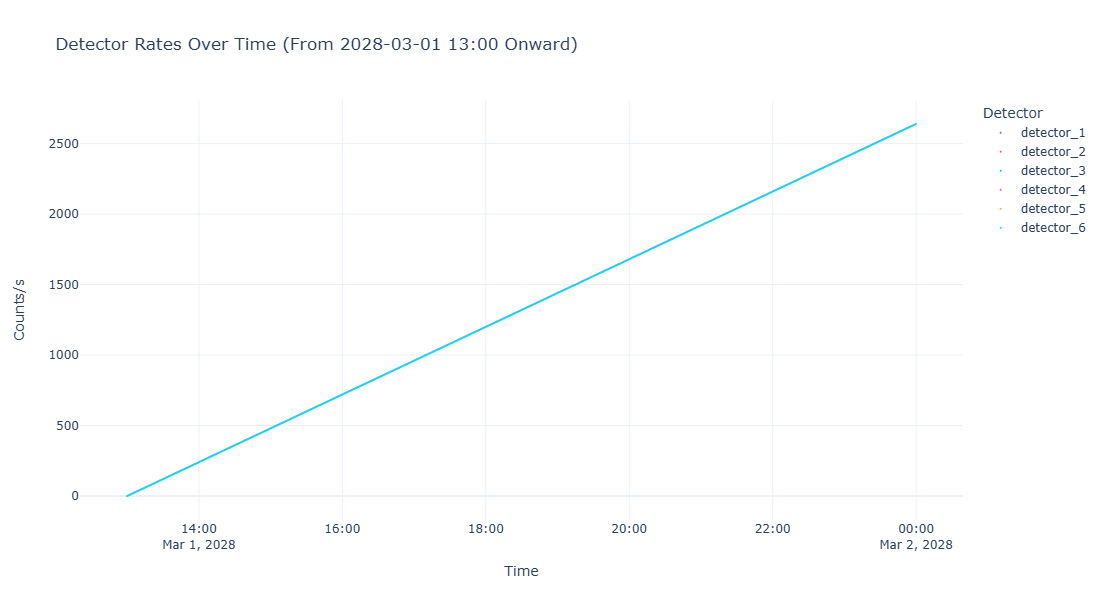

In [7]:
import plotly.express as px

fig = px.scatter(
    clean_rates_df,
    x="timestamp",
    y=[f"detector_{i}" for i in range(1, 7)],
    labels={"value": "Counts/s", "variable": "Detector"},
    title="Detector Rates Over Time (From 2028-03-01 13:00 Onward)"
)

fig.update_traces(marker=dict(size=2))
fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Counts/s",
    legend_title="Detector",
    template="plotly_white",
    height=600,
    width=1000
)

fig.show()

The points of the plot with counts bounded between 500 and 900 are one per detector right after the big group and one per detector right before the next big group of points. They are separated by about 18 minutes.

Check normality assumption for a small segment (some minutes) of data points for detector 1.

Random time window: 2028-03-01 16:12:13 to 2028-03-01 16:17:13


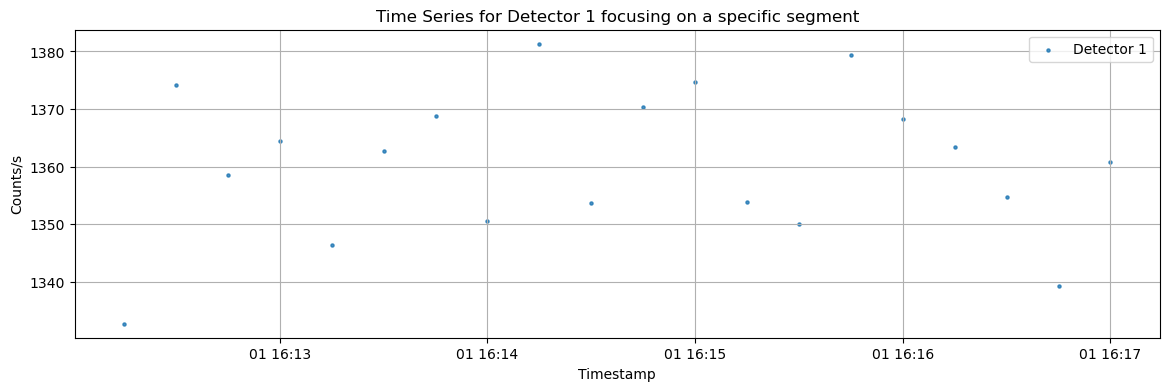

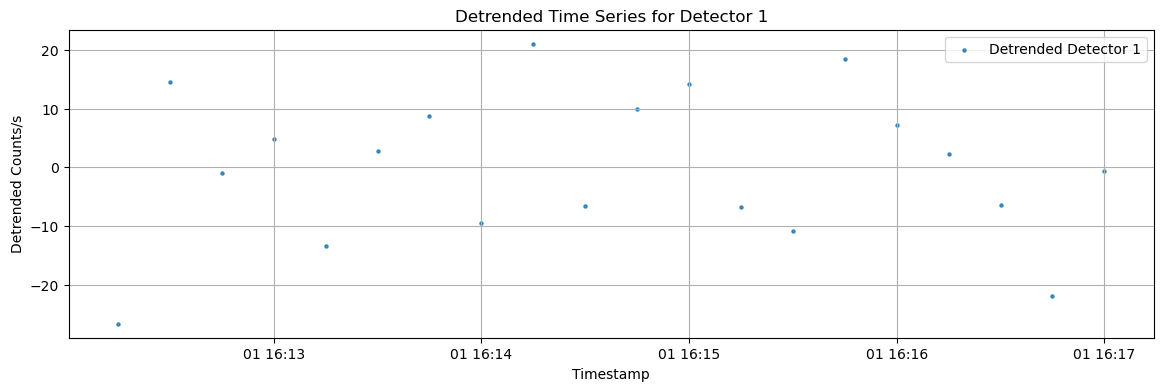

Shapiro-Wilk Test: stat=0.980, p=0.937
Shapiro-Wilk Test on detrended data: stat=0.978, p=0.905


In [8]:
from scipy.stats import shapiro  


start = pd.Timestamp("2028-03-01 15:01:45")
end = pd.Timestamp("2028-03-01 16:26:15")
# Generate a random start time within the range
n_min = 5  # Number of minutes for the time window
random_start = start + pd.Timedelta(seconds=np.random.randint(0, int((end - start).total_seconds() - 60*n_min)))

# Define the random end time as 5 minutes after the random start time
random_end = random_start + pd.Timedelta(minutes=n_min)

print(f"Random time window: {random_start} to {random_end}")

# Load or select your time series segment
y = clean_rates_df.loc[
    (clean_rates_df["timestamp"] >= random_start) & (clean_rates_df["timestamp"] <= random_end),
    "detector_1"
].values
x = clean_rates_df.loc[
    (clean_rates_df["timestamp"] >= random_start) & (clean_rates_df["timestamp"] <= random_end),
    "timestamp"
].values
# Plot the time series
plt.figure(figsize=figsize)
plt.scatter(x, y, label="Detector 1", s=5, alpha=0.8)
plt.xlabel("Timestamp")
plt.ylabel("Counts/s")
plt.title("Time Series for Detector 1 focusing on a specific segment")
plt.legend()
plt.grid()
plt.show()

# OPTIONAL: Detrend if you see strong trends
from scipy.signal import detrend
y_detrended = detrend(y)

# Plot y_detrended
plt.figure(figsize=figsize)
plt.scatter(x, y_detrended, label="Detrended Detector 1", s=5, alpha=0.8)
plt.xlabel("Timestamp")
plt.ylabel("Detrended Counts/s")
plt.title("Detrended Time Series for Detector 1")
plt.legend()
plt.grid()
plt.show()

# Shapiro-Wilk test
stat, p = shapiro(y)
print('Shapiro-Wilk Test: stat=%.3f, p=%.3f' % (stat, p))
stat, p = shapiro(y_detrended)
print('Shapiro-Wilk Test on detrended data: stat=%.3f, p=%.3f' % (stat, p))

By focusing on a very short segment (5 minutes) in which we assume the time series is stationary, the data follows a normal distribution. If we enlarge the window the assumption falls as the series is not stationary anymore.

Checking correlation of orientation variables against each of the detectors

In [8]:
# Select non-time orientation variables
orientation_vars = ["x_lat", "x_lon", "z_lat", "z_lon", "altitude_km", "Earth_lat", "Earth_lon"]

# Calculate Pearson correlation for each orientation variable against each detector
correlation_results = {}
for orientation_var in orientation_vars:
    correlation_results[orientation_var] = clean_rates_df.drop(columns=["timestamp"]).corrwith(ori_df[orientation_var])

# Convert the results to a DataFrame for better visualization
correlation_df = pd.DataFrame(correlation_results, index=[f"detector_{i}" for i in range(1, 7)])
print(correlation_df)

               x_lat     x_lon     z_lat     z_lon  altitude_km  Earth_lat  \
detector_1  0.323123 -0.502109 -0.479902  0.285006     0.381607  -0.007065   
detector_2  0.326076 -0.492741 -0.484818  0.273762     0.381724  -0.014969   
detector_3  0.330629 -0.506047 -0.475946  0.286416     0.378564  -0.006990   
detector_4  0.343494 -0.469266 -0.494905  0.238977     0.377739  -0.039763   
detector_5  0.333095 -0.484599 -0.492885  0.265710     0.386736  -0.024318   
detector_6  0.339893 -0.492744 -0.481437  0.261543     0.371655  -0.021022   

            Earth_lon  
detector_1  -0.634290  
detector_2  -0.640353  
detector_3  -0.624495  
detector_4  -0.648588  
detector_5  -0.642493  
detector_6  -0.633929  


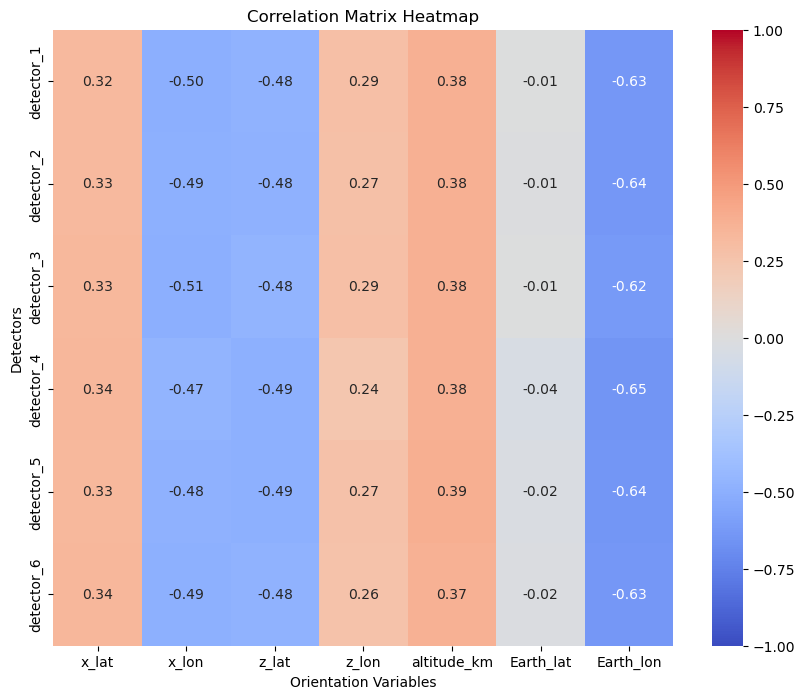

In [9]:
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.xlabel("Orientation Variables")
plt.ylabel("Detectors")
plt.show()

As expected, given all detectors show very similar pattern, there is no significant difference between the rows of the heatmap, meaning all detectors have similar correlations with the orientation variables.  
The earth longitude of the satellite is the most correlated predicotr, while the earth latitude is not relevant. The other variables show a moderate linear correlation.

Checking correlation matrix and mutual information between potential predictors.

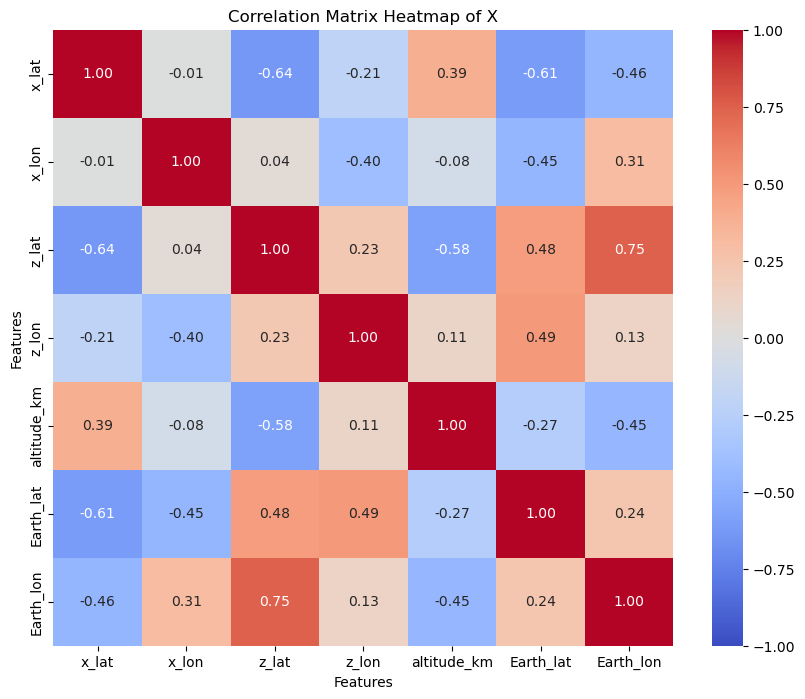

In [13]:
# Remove 'timestamp' column
X = ori_df.drop(columns=['timestamp'])
# Compute the correlation matrix
correlation_matrix = X.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap of X")
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()

There is high linear correlation between z_lat and Earth_lon suggesting it might be redundant to use both as predictors.  
Other correlations are moderate or low.

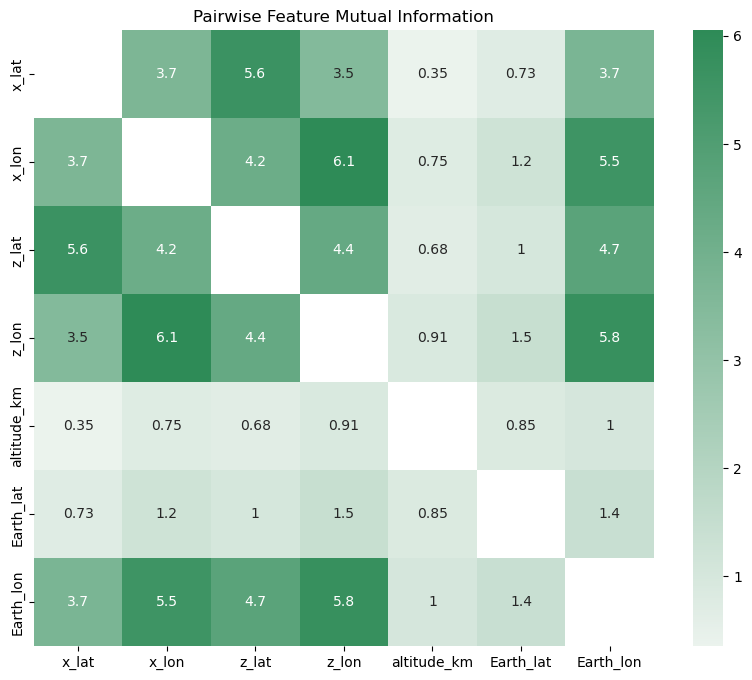

In [ ]:
from sklearn.feature_selection import mutual_info_regression

# Prepare MI matrix
features = X.columns
mi_matrix = pd.DataFrame(index=features, columns=features)

for i, feat_i in enumerate(features):
    for j, feat_j in enumerate(features):
        if i == j:
            mi_matrix.loc[feat_i, feat_j] = np.nan  # Diagonal is undefined/self
        else:
            # Compute MI between feat_i and feat_j
            # We treat feat_j as the "target" here, just for MI computation
            mi = mutual_info_regression(X[[feat_i]], X[feat_j], discrete_features=False)
            mi_matrix.loc[feat_i, feat_j] = mi[0]

# Convert all to float for plotting
mi_matrix = mi_matrix.astype(float)
plt.figure(figsize=(10, 8))
sns.heatmap(mi_matrix, annot=True, cmap=sns.light_palette("seagreen", as_cmap=True))
plt.title('Pairwise Feature Mutual Information')
plt.show()

The mutual information heatmap, which detect any relationship other than linear association, shows slightly different results compared to the correlation plot.